# CPPNs in GLSL

This code is for the NIPS Creativity Workshop submission "Interactive CPPNs in GLSL"

Significantly modified from the Mordvintsev et al's original CPPN notebook available here: https://github.com/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/xy2rgb.ipynb

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
!pip install -q lucid>=0.2.3

In [3]:
import numpy as np

import tensorflow as tf
from tensorflow.contrib import slim

from IPython.display import display

In [4]:
from lucid.modelzoo import vision_models
from lucid.misc.io import show, save, load
from lucid.optvis import objectives
from lucid.optvis import render
from lucid.misc.tfutil import create_session

In [5]:
model = vision_models.InceptionV1()
model.load_graphdef()

## Let's first define our CPPN models

In [6]:
def composite_activation(x):
    x = tf.atan(x)
    # Coefficients computed by:
    #   def rms(x):
    #     return np.sqrt((x*x).mean())
    #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
    #   print(rms(a), rms(a*a))
    return tf.concat([x/0.67, (x*x)/0.6], -1)


def composite_activation_unbiased(x):
    x = tf.atan(x)
    # Coefficients computed by:
    #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
    #   aa = a*a
    #   print(a.std(), aa.mean(), aa.std())
    return tf.concat([x/0.67, (x*x-0.45)/0.396], -1)


def relu_normalized(x):
    x = tf.nn.relu(x)
    xx = tf.nn.relu(-x)
    # Coefficients computed by:
    #   a = np.random.normal(0.0, 1.0, 10**6)
    #   a = np.maximum(a, 0.0)
    #   print(a.mean(), a.std())
    return tf.concat([(x-0.40)/0.58, (xx-0.40)/0.58], -1)

def periodic_activation(x):
    return tf.concat([tf.sin(x)/0.5, tf.cos(x)/0.5], -1)

def modulo_activation(x):
    return tf.concat([tf.mod(x, 2.0), tf.mod(x+1.0, 2.0)], -1)

def modsin_activation(x):
    return tf.concat([tf.mod(x, 2.0*3.14159)/(2.0*3.14159)-0.5, tf.sin(x)/0.5], -1)

def image_cppn(
    size,
    num_output_channels=3,
    num_hidden_channels=24,
    num_layers=8,
    batch_size=1,
    activation_fn=composite_activation,
    biases_initializer=None,
    weights_initializer=None,
    include_meshgrid=True,
    include_sininput=False,
    jitter_input=None,
    weights_regularizer=None,
    num_noise_channels=-1,
    
    normalize=False):
    '''
    Allowed 'activation_fn' to be a list as well to have different activations per layer.
    If `num_noise_channels > 0`, will not feed in meshgrid, but rather multiple channels of different
    scaled noise
    '''
    r = 3.0**0.5  # std(coord_range) == 1.0
    coord_range = tf.linspace(-r, r, size)
    net = None
    if num_noise_channels > 0:
        channel_size = size
        noise_channels = []
        for octave_i in range(num_noise_channels):
            noise_channel = tf.random_normal((batch_size, channel_size, channel_size, 1))
            dy, dx = tf.image.image_gradients(noise_channel)
            noise_channels.extend([tf.image.resize_bicubic(noise_channel, (size, size)),
                                   tf.image.resize_bicubic(dy, (size, size)),
                                   tf.image.resize_bicubic(dx, (size, size))
                                  ])
            channel_size = int(np.ceil(channel_size/2))
        net = tf.concat(noise_channels, -1)
    if include_meshgrid:
        y, x = tf.meshgrid(coord_range, coord_range, indexing='ij')
        meshstack = tf.tile(tf.expand_dims(tf.stack([x, y], -1), 0), (batch_size, 1, 1, 1))  # add batch dimension
        if jitter_input is not None:
            meshstack = meshstack + tf.random_uniform((batch_size, 1, 1, 2),
                                                      minval = jitter_input[0], maxval=jitter_input[1])
        if net is None:
            net = meshstack
        else:
            net = tf.concat([net, meshstack], -1)
    if include_sininput:
        y, x = tf.meshgrid(coord_range, coord_range, indexing='ij')
        meshstack = tf.tile(tf.expand_dims(tf.stack([x, y], -1), 0), (batch_size, 1, 1, 1))  # add batch dimension
        if net is None:
            net = meshstack
        else:
            net = tf.concat([net, meshstack], -1)
        
    with slim.arg_scope([slim.conv2d], kernel_size=1, activation_fn=None,
                        weights_regularizer=weights_regularizer):
        for i in range(num_layers):
            in_n = int(net.shape[-1])
            if isinstance(num_hidden_channels, list):
                hidden = num_hidden_channels[i]
            else:
                hidden = num_hidden_channels
                
            if isinstance(biases_initializer, list):
                layer_bias_initializer = biases_initializer[i]
            else:
                layer_bias_initializer = biases_initializer
            if layer_bias_initializer is None:
                layer_bias_initializer = tf.zeros_initializer()
                
            if isinstance(weights_initializer, list):
                layer_weight_initializer = weights_initializer[i]
            else:
                layer_weight_initializer = weights_initializer
            if layer_weight_initializer is None:
                layer_weight_initializer = tf.random_normal_initializer(0.0, np.sqrt(1.0/in_n))

            net = slim.conv2d(
                net, hidden,
                # this is untruncated version of tf.variance_scaling_initializer
                weights_initializer = layer_weight_initializer,
                biases_initializer = layer_bias_initializer,
            )
            
            if normalize:
                net = slim.instance_norm(net)
                
            if isinstance(activation_fn, list):
                net = activation_fn[i](net)
            else:
                net = activation_fn(net)

        rgb = slim.conv2d(net, num_output_channels, activation_fn=tf.nn.sigmoid,
                          weights_initializer=tf.zeros_initializer())
    return rgb

## And the code to learn a CPPN that visualizes a feature using lucid

In [7]:
def eval_model(iters=200, show_every=50, show_num=5, target="mixed4b_pool_reduce_pre_relu:16", cppn_params = {},
              optimizer_params = {"learning_rate": 0.005}):
    '''
    This function "trains" the CPNN (optimizes its weights to activate a particular neuron in the Inception model)
    and then returns a list of numpy arrays of [(weight, bias)] tuples.
    These can be used to output GLSL code in the subsequent step.
    '''
        
    with tf.Graph().as_default() as graph, tf.Session() as sess:
        cppn_f = image_cppn(224, **cppn_params)
        optimizer = tf.train.AdamOptimizer(**optimizer_params)

        T = render.make_vis_T(model, target, param_f=cppn_f, optimizer=optimizer)
        
        loss, vis_op, t_image = T("loss"), T("vis_op"), T("input")
        tf.initialize_all_variables().run()
        to_show = []

        try:
            for i in range(iters):
                T("vis_op").run()
                print(f"{i}: {loss.eval():.3}", end=",", flush=True)
                to_show.append(t_image.eval()) # Should probably only do this when I know I'll show it.
                to_show = to_show[-show_num:]
                if (i+1)%show_every == 0:
                    show(np.concatenate(to_show, 0))
        except KeyboardInterrupt:
            print("INTERRUPTED")
        
        evaled = [var.eval() for var in cppn_f.graph.get_collection('trainable_variables')]
        grouped = []
        print(len(evaled))
        print([var.name for var in cppn_f.graph.get_collection('trainable_variables')])
        # Rearrange it into a nice dictionary
        for pos in range(0, len(evaled), 2):
            # This isn't completely elegant. I try to figure out what the activation
            # of this layer was, but I have to repeat some of th defaults inside the call
            # to image_cppn to do so.
            activation_fn = cppn_params.get('activation_fn', composite_activation)
            if isinstance(activation_fn, list):
                if pos//2 < len(activation_fn):
                    activation_fn = activation_fn[pos//2]
                else:
                    # This is a bit of a hack, the last layer is hardcoded to sigmoid activation
                    activation_fn = tf.nn.sigmoid
            grouped.append({'weights': evaled[pos], 
                           'bias': evaled[pos+1],
                            'activation': activation_fn
                           })
        return grouped

## Code to convert to GLSL

In [8]:
import numpy as np

def cppn_to_glsl(layers, fn_name="cppn_fn", mode="shadertoy", verbose=False,
                fix_aspect=True):
    '''
    Given a list of dicts defining layers of a trained CPPN (as returned by the above `eval_model` function) 
    generate GLSL code.
    
    The `mode` parameter can be one of the following:
    "shadertoy":
        Exports code compatible with the ShaderToy editor at http://shadertoy.com
    "bookofshaders":
        Exports code compatible with the Book Of Shaders editor here http://editor.thebookofshaders.com/
    "td":
        Exports code compatible with TouchDesigner: can be dropped into a "GLSL TOP"
        (see https://docs.derivative.ca/GLSL_TOP). TouchDesigner can be found at http://derivative.ca
    '''
    
    # the xy2rgb cppn's internal size is the output of its first layer (pre-activation)
    # so will just inspect that to figure it out
    n_hidden = layers[0]['weights'].shape[-1]
    if n_hidden%4 != 0:
        raise ValueError("Currently only support multiples of 4 for hidden layer size")
    modes = {"shadertoy", "bookofshaders", "td"}
    if mode not in modes:
        raise ValueError(f"Mode {mode} not one of the supported modes: {modes}")
        
    if mode == "bookofshaders":
        snippet =f"""
#ifdef GL_ES
precision lowp float;
#endif

uniform vec2 u_resolution;
uniform vec2 u_mouse;
uniform float u_time;
"""
    elif mode == "shadertoy":
        snippet = ""
    elif mode == "td":
        snippet = f"""
uniform float uIn0;
uniform float uIn1;
uniform float uIn2;
uniform float uIn3;

out vec4 fragColor;
        """
    
    snippet += f"""
#define N_HIDDEN {n_hidden}

vec4 bufA[N_HIDDEN/4];
vec4 bufB[N_HIDDEN/2];


vec4 {fn_name}(vec2 coordinate, float in0, float in1, float in2, float in3) {{
    vec4 tmp;
    bufB[0] = vec4(coordinate.x, coordinate.y, 0., 0.);
"""
    def vec(a):
        '''Take a Python array of length four (or less) and output code for
        a GLSL vec4, possibly zero-padded at the end'''
        if len(a) == 4:
            return f"vec4({','.join(str(x) for x in a)})"
        else:
            assert len(a) < 4 , "Length must less than 4"
            return vec(np.concatenate([a, [0.]*(4-len(a))]))
    
    def mat(a):
        '''Tak a numpy matrix of 4 rows and 4 or fewer columns, and output GLSL code
        for a mat4, possibly with zeros padded in the final columns'''
        if a.shape[0] < 4:
            m2 = np.vstack([a, [[0.,0.,0.,0.]] * (4 - a.shape[0])])
            return mat(m2)
        assert a.shape[0] == 4, f"Expected a of shape (4,n<=4). Got: {a.shape}."
        return f"mat4({','.join(vec(row) for row in a)})"
    
    for layer_i, layer_dict in enumerate(layers):
        weight = layer_dict['weights']
        bias = layer_dict['bias']
        activation = layer_dict['activation']
        
        _, _, from_size, to_size = weight.shape
        if verbose:
            print(f"Processing layer {layer_i}. from_size={from_size}, to_size={to_size}")
        
        # First, compute the transformation from the last layer into bufA
        for to_index in range(max(1,to_size//4)):
            #Again, the max(1) is important here, because to_size is 3 for the last layer!
            if verbose: print(f"  generating output {to_index} into bufA")
            snippet += f"bufA[{to_index}] = {vec(bias[to_index*4:to_index*4+4])}"
            for from_index in range(max(1,from_size//4)):
                # the "max" in the above loop gives us a special case for the first layer,
                # where there are only two inputs.
                snippet += f" + {mat(weight[0, 0, from_index*4:from_index*4+4, to_index*4:to_index*4+4])} * bufB[{from_index}]"
            if layer_i == 3:
                snippet += f" + in{to_index%4}"
            snippet += f";\n"
            
        if to_size != 3:
            if verbose: print("  Doing the activation into bufB ")
            for to_index in range(to_size//4):
                if activation == composite_activation:
                    snippet += f"tmp = atan(bufA[{to_index}]);\n"
                    snippet += f"bufB[{to_index}] = tmp/0.67;\n"
                    snippet += f"bufB[{to_index + to_size//4}] = (tmp*tmp) / 0.6;\n"
                elif activation == composite_activation_unbiased:
                    snippet += f"tmp = atan(bufA[{to_index}]);\n"
                    snippet += f"bufB[{to_index}] = tmp/0.67;\n"
                    snippet += f"bufB[{to_index + to_size//4}] = (tmp*tmp - 0.45) / 0.396;\n"
                    # return tf.concat([x/0.67, (x*x-0.45)/0.396], -1)
                elif activation == periodic_activation:
                    snippet += f"bufB[{to_index}] = sin(bufA[{to_index}]);\n"
                    snippet += f"bufB[{to_index + to_size//4}] = cos(bufA[{to_index}]);\n"
                elif activation == modulo_activation:
                    snippet += f"bufB[{to_index}] = mod(bufA[{to_index}], 2.0);\n"
                    snippet += f"bufB[{to_index + to_size//4}] = mod(bufA[{to_index}]+1.0, 2.0);\n"
                elif activation == modsin_activation:
                    snippet += f"bufB[{to_index}] = mod(bufA[{to_index}], 2.0*3.14159) / (2.0*3.14159) - 0.5;\n"
                    snippet += f"bufB[{to_index + to_size//4}] = sin(bufA[{to_index}]) / 0.5;\n"
    #                return tf.concat([tf.mod(x, 2.0*3.14159)/(2.0*3.14159)-0.5, tf.sin(x)/0.5], -1)

                elif activation == relu_normalized:
                    snippet += f"bufB[{to_index}] = (max(bufA[{to_index}], 0.) - 0.4 / 0.58);\n"
                    snippet += f"bufB[{to_index + to_size//4}] = (max(-bufA[{to_index}], 0.) - 0.4 / 0.58);\n"

                    #return (x-0.40)/0.58
                    # return tf.concat([(x-0.40)/0.58, (xx-0.40)/0.58], -1)
                else:
                    raise ValueError(f"Unknown activation: {activation.__name__}")
        else:
            if verbose:
                print("  Sigmoiding the last layer")
            # We just do a sigmoid at the last layer.
            sigmoider = lambda s: f"1. / (1. + exp(-{s}))"
            snippet += f"return vec4(({sigmoider('bufA[0]')}).xyz, 1.0);\n"
    snippet += "}\n"
    if mode=="bookofshaders":
        snippet += f"""
void main() {{
    vec2 st = gl_FragCoord.xy/u_resolution.xy;
"""
        if fix_aspect:
            snippet += f"""
    st.x *= u_resolution.x/u_resolution.y;
    st.x -= ((u_resolution.x / u_resolution.y) - 1.) /2.;
"""
        snippet += f"""
    st = vec2(1., -1.) * 2. * (st - vec2(0.5, 0.5));

    gl_FragColor = {fn_name}(st, sin(u_time), sin(2.*u_time), sin(3.*u_time), sin(4.*u_time));
}}
"""
    elif mode == "shadertoy":
        snippet += f"""
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {{
    // Normalized pixel coordinates (from 0 to 1)
    vec2 uv = fragCoord/iResolution.xy;
    vec2 mouseNorm = (iMouse.xy / iResolution.xy) - vec2(0.5, 0.5);

"""
        if fix_aspect:
            snippet += f"""
    uv.x *= iResolution.x / iResolution.y;
    uv.x -= ((iResolution.x / iResolution.y) - 1.) /2.;
"""
        snippet += f"""

    // Shifted to the form expected by the CPPN
    uv = vec2(1., -1.) * 2. * (uv - vec2(0.5, 0.5));
    // Output to screen
    fragColor = {fn_name}(uv, sin(iTime), sin(2.*iTime), sin(3.*iTime), sin(4.*iTime));
}}
        """
    elif mode == "td":
        snippet += f"""
void main() {{
    // Normalized pixel coordinates (from 0 to 1)
    vec2 uv = vUV.xy;
"""
        if fix_aspect:
            snippet += f"""
    // TODO: don't kow how to find the resolution of the GLSL Top output to fix aspect...
"""
        snippet += f"""

    // Shifted to the form expected by the CPPN
    uv.xy = vec2(1., -1.) * 2. * (uv.xy - vec2(0.5, 0.5));
    // Output to screen
    fragColor = TDOutputSwizzle({fn_name}(uv.xy, uIn0, uIn1, uIn2, uIn3));
}}
        """
    return snippet

## Let's try it out!

In [9]:
strings = {
    'orig': 'mixed4a_pre_relu:16',
    'flowers': 'mixed4b_pool_reduce_pre_relu:16',
    'cars': 'mixed4b_3x3_pre_relu:77',
    # many channels to try from the Google xy2rgb notebook
    'goog0': 'mixed4c_pool_reduce_pre_relu:5',
    'goog1': 'softmax0_pre_activation/matmul:316',
    'goog2': 'mixed4b_3x3_pre_relu:77',
    'goog3': 'mixed4d_3x3_bottleneck_pre_relu:114',
    'goog4': 'mixed4e_3x3_pre_relu:120',
    'goog5': 'head0_bottleneck_pre_relu:0',
    'goog6': 'mixed4d_3x3_bottleneck_pre_relu:139',
}

Instructions for updating:
Use `tf.global_variables_initializer` instead.


Instructions for updating:
Use `tf.global_variables_initializer` instead.


0: -5.55,1: -6.43,2: 11.5,3: -3.69,4: -2.26,5: 11.4,6: -4.15,7: 4.2,8: -6.31,9: 1.05,10: 18.1,11: 0.0772,12: 7.88,13: -5.69,14: -0.401,15: -6.59,16: 0.544,17: 4.82,18: 1.27,19: 2.08,20: 0.603,21: 11.0,22: 7.8,23: 8.36,24: 3.46,


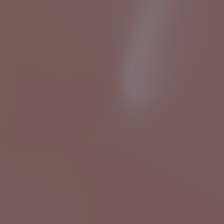
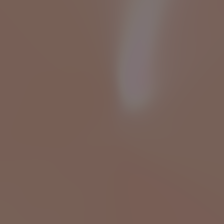
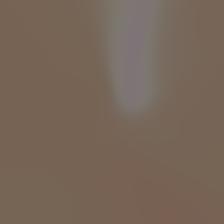
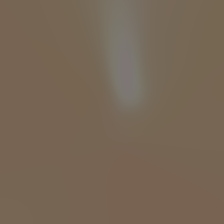
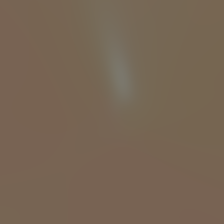

25: 0.913,26: 14.6,27: 6.44,28: 5.17,29: 3.3,30: 6.82,31: -0.103,32: -0.533,33: 20.2,34: 17.8,35: 4.64,36: 7.78,37: 9.84,38: 10.8,39: 29.7,40: 17.3,41: 12.8,42: 16.7,43: 16.4,44: 40.8,45: 17.2,46: 30.7,47: 17.4,48: 21.8,49: 25.8,


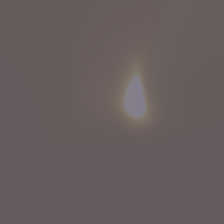
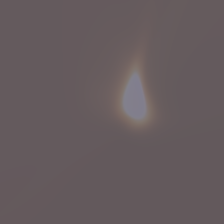
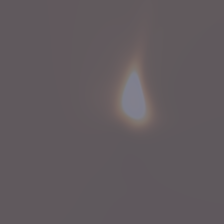
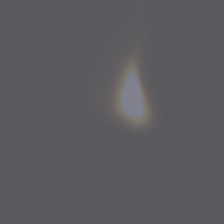
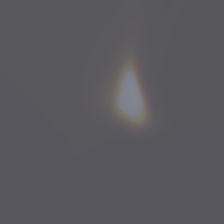

50: 47.4,51: 35.7,52: 47.5,53: 44.4,54: 33.5,55: 18.2,56: 39.0,57: 33.6,58: 46.5,59: 32.3,60: 21.5,61: 38.4,62: 60.2,63: 22.3,64: 41.6,65: 44.6,66: 63.5,67: 57.2,68: 28.5,69: 34.8,70: 42.1,71: 23.0,72: 35.5,73: 25.9,74: 36.4,


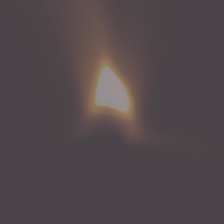
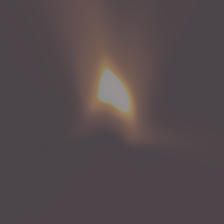
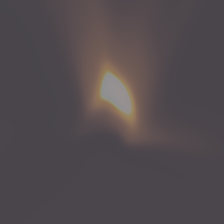
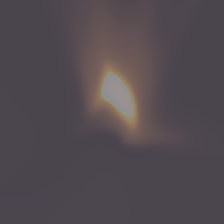
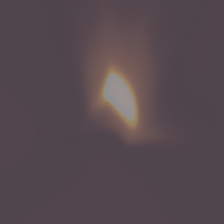

75: 26.6,76: 35.0,77: 21.9,78: 46.9,79: 48.8,80: 37.1,81: 37.5,82: 53.8,83: 44.8,84: 58.6,85: 29.8,86: 45.9,87: 40.0,88: 37.4,89: 58.1,90: 50.2,91: 58.9,92: 48.0,93: 50.8,94: 51.1,95: 43.3,96: 47.2,97: 38.5,98: 44.3,99: 50.1,


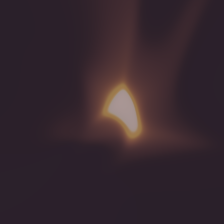
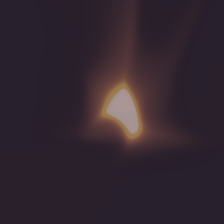
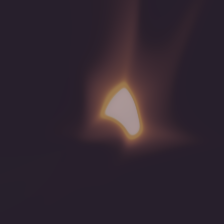
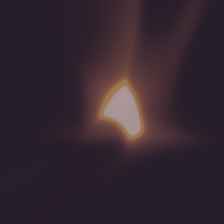
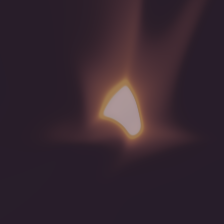

100: 47.2,101: 53.3,102: 56.9,103: 51.6,104: 48.4,105: 56.7,106: 36.7,107: 46.9,108: 38.8,109: 47.3,110: 65.5,111: 50.6,112: 72.8,113: 62.7,114: 41.4,115: 70.2,116: 58.9,117: 39.7,118: 45.6,119: 48.8,120: 48.8,121: 55.8,122: 47.9,123: 51.3,124: 48.6,


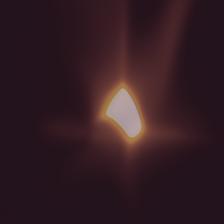
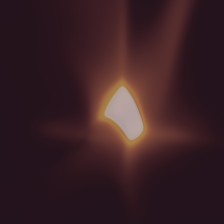
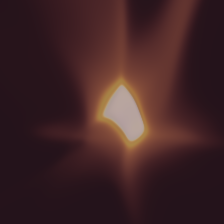
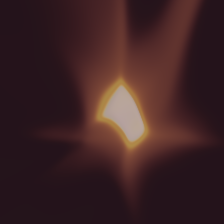
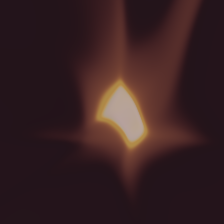

125: 48.7,126: 73.2,127: 73.4,128: 58.0,129: 51.9,130: 87.6,131: 57.1,132: 67.7,133: 64.1,134: 58.7,INTERRUPTED
20
['Conv/weights:0', 'Conv/biases:0', 'Conv_1/weights:0', 'Conv_1/biases:0', 'Conv_2/weights:0', 'Conv_2/biases:0', 'Conv_3/weights:0', 'Conv_3/biases:0', 'Conv_4/weights:0', 'Conv_4/biases:0', 'Conv_5/weights:0', 'Conv_5/biases:0', 'Conv_6/weights:0', 'Conv_6/biases:0', 'Conv_7/weights:0', 'Conv_7/biases:0', 'Conv_8/weights:0', 'Conv_8/biases:0', 'Conv_9/weights:0', 'Conv_9/biases:0']


In [10]:
evaled_model = eval_model(500, show_every=25, 
                          target=strings['goog3'],
                          cppn_params={"num_hidden_channels": 16, 'num_layers': 9,
                                        "biases_initializer": tf.random_uniform_initializer(-.5, .5),
                                      'activation_fn': composite_activation})

## Output this trained CPPN to Shadertoy
The code output below can be dropped into the [Shadertoy editor](http://shadertoy.com) or, by changing the mode to "bookofshaders" to the [Book Of Shaders editor](http://editor.thebookofshaders.com).

In [11]:
print(cppn_to_glsl(evaled_model, mode="shadertoy", verbose=False, fix_aspect=True))


#define N_HIDDEN 16

vec4 bufA[N_HIDDEN/4];
vec4 bufB[N_HIDDEN/2];


vec4 cppn_fn(vec2 coordinate, float in0, float in1, float in2, float in3) {
    vec4 tmp;
    bufB[0] = vec4(coordinate.x, coordinate.y, 0., 0.);
bufA[0] = vec4(0.16468193,-0.18223391,-0.50609505,0.307364) + mat4(vec4(-0.39581459760665894,0.819929301738739,-0.6268230080604553,-1.1757290363311768),vec4(0.5404884219169617,-0.6349309086799622,0.5576810836791992,-1.031472086906433),vec4(0.0,0.0,0.0,0.0),vec4(0.0,0.0,0.0,0.0)) * bufB[0];
bufA[1] = vec4(-0.2908669,0.30299583,0.16767266,0.28702968) + mat4(vec4(0.6757239103317261,-0.3413659930229187,1.177363634109497,-0.5230672359466553),vec4(0.2450435310602188,-1.3542380332946777,-1.2633419036865234,-0.3293358385562897),vec4(0.0,0.0,0.0,0.0),vec4(0.0,0.0,0.0,0.0)) * bufB[0];
bufA[2] = vec4(0.45857143,-0.19051406,0.00010839745,0.120912075) + mat4(vec4(-0.06202641874551773,1.063613772392273,-0.10034878551959991,-1.5110723972320557),vec4(-0.951640784740448,0.682076096534729,0.